In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA, COBYLA, ADAM
from qiskit.primitives import Sampler
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import EfficientSU2

✅ Step 1: Data Preparation (Binary Classification)

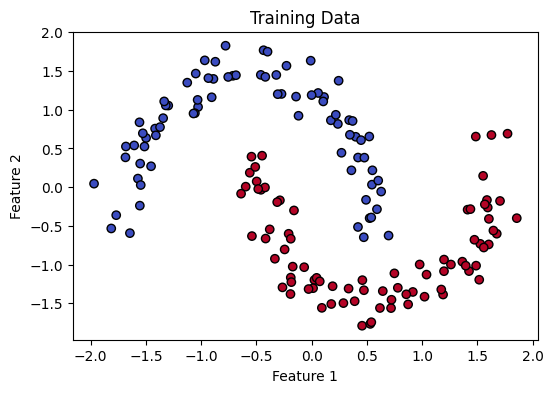

In [40]:
# Generate dataset (moons dataset)
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Plot the dataset
plt.figure(figsize=(6, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.title("Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


 Step 2: Quantum Feature Map (Data Encoding)

In [53]:
# Define the quantum feature map (ZZFeatureMap for encoding data into quantum states)
#feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

# Alternative: Use PauliFeatureMap for better expressiveness
from qiskit.circuit.library import ZZFeatureMap

# Adjust the feature map to match the ansatz dimensions (4 qubits)
# feature_map = ZZFeatureMap(feature_dimension=4, reps=2)

# Use a more expressive feature map
feature_map = PauliFeatureMap(feature_dimension=4, reps=3, paulis=['X', 'Y', 'ZZ'])


✅ What This Does:

Encodes the 2D dataset into a quantum Hilbert space.
feature_dimension=2 because we have two features (x, y).
reps=2 increases the complexity of the mapping.

In [42]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector

def custom_ansatz(num_qubits, num_layers):
    circuit = QuantumCircuit(num_qubits)
    params = ParameterVector('θ', length=num_qubits * num_layers * 2)  # 2 params per qubit per layer

    param_index = 0
    # Build layers
    for layer in range(num_layers):
        # Apply parameterized rotations to each qubit
        for qubit in range(num_qubits):
            circuit.rx(params[param_index], qubit)
            circuit.rz(params[param_index + 1], qubit)
            param_index += 2

        # Apply entanglement (nearest-neighbor CNOTs)
        for qubit in range(num_qubits - 1):
            circuit.cx(qubit, qubit + 1)

    return circuit

# Test the ansatz
num_qubits = 4  # Using 4 qubits to capture more complex interactions
num_layers = 5  # More layers for higher expressiveness
ansatz = custom_ansatz(num_qubits=num_qubits, num_layers=num_layers)

# Visualize the custom ansatz
ansatz.draw('text')

┌──────────┐┌──────────┐     ┌──────────┐ ┌──────────┐             »
q_0: ┤ Rx(θ[0]) ├┤ Rz(θ[1]) ├──■──┤ Rx(θ[8]) ├─┤ Rz(θ[9]) ├─────────────»
     ├──────────┤├──────────┤┌─┴─┐└──────────┘┌┴──────────┤┌───────────┐»
q_1: ┤ Rx(θ[2]) ├┤ Rz(θ[3]) ├┤ X ├─────■──────┤ Rx(θ[10]) ├┤ Rz(θ[11]) ├»
     ├──────────┤├──────────┤└───┘   ┌─┴─┐    └───────────┘├───────────┤»
q_2: ┤ Rx(θ[4]) ├┤ Rz(θ[5]) ├────────┤ X ├──────────■──────┤ Rx(θ[12]) ├»
     ├──────────┤├──────────┤        └───┘        ┌─┴─┐    ├───────────┤»
q_3: ┤ Rx(θ[6]) ├┤ Rz(θ[7]) ├─────────────────────┤ X ├────┤ Rx(θ[14]) ├»
     └──────────┘└──────────┘                     └───┘    └───────────┘»
«                  ┌───────────┐┌───────────┐                          »
«q_0: ──────■──────┤ Rx(θ[16]) ├┤ Rz(θ[17]) ├───────────────────■──────»
«         ┌─┴─┐    └───────────┘├───────────┤┌───────────┐    ┌─┴─┐    »
«q_1: ────┤ X ├──────────■──────┤ Rx(θ[18]) ├┤ Rz(θ[19]) ├────┤ X ├────»
«     ┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐»
«q_2: ┤ Rz(θ[13]) ├────┤ X ├──────────■──────┤ Rx(θ[20]) ├┤ Rz(θ[21]) ├»
«     ├───────────┤    └───┘        ┌─┴─┐    ├───────────┤├───────────┤»
«q_3: ┤ Rz(θ[15]) ├─────────────────┤ X ├────┤ Rx(θ[22]) ├┤ Rz(θ[23]) ├»
«     └───────────┘                 └───┘    └───────────┘└───────────┘»
«     ┌───────────┐┌───────────┐                          ┌───────────┐»
«q_0: ┤ Rx(θ[24]) ├┤ Rz(θ[25]) ├───────────────────■──────┤ Rx(θ[32]) ├»
«     └───────────┘├───────────┤┌───────────┐    ┌─┴─┐    └───────────┘»
«q_1: ──────■──────┤ Rx(θ[26]) ├┤ Rz(θ[27]) ├────┤ X ├──────────■──────»
«         ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    »
«q_2: ────┤ X ├──────────■──────┤ Rx(θ[28]) ├┤ Rz(θ[29]) ├────┤ X ├────»
«         └───┘        ┌─┴─┐    ├───────────┤├───────────┤    └───┘    »
«q_3: ─────────────────┤ X ├────┤ Rx(θ[30]) ├┤ Rz(θ[31]) ├─────────────»
«                      └───┘    └───────────┘└───────────┘             »
«     ┌───────────┐                                    
«q_0: ┤ Rz(θ[33]) ├───────────────────■────────────────
«     ├───────────┤┌───────────┐    ┌─┴─┐              
«q_1: ┤ Rx(θ[34]) ├┤ Rz(θ[35]) ├────┤ X ├──────■───────
«     └───────────┘├───────────┤┌───┴───┴───┐┌─┴─┐     
«q_2: ──────■──────┤ Rx(θ[36]) ├┤ Rz(θ[37]) ├┤ X ├──■──
«         ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐
«q_3: ────┤ X ├────┤ Rx(θ[38]) ├┤ Rz(θ[39]) ├─────┤ X ├
«         └───┘    └───────────┘└───────────┘     └───┘

✅ Step 3: Define the Variational Quantum Classifier (VQC)

In [43]:
# Create variational circuit (trainable ansatz)
#ansatz = RealAmplitudes(num_qubits=2, reps=2)

# Choose a better optimizer
optimizer = COBYLA(maxiter=300)  # or ADAM(maxiter=300)

# Alternative Ansatz: More expressiveness
ansatz = EfficientSU2(num_qubits=4, reps=4, entanglement='full')

# Initialize sampler for quantum execution
sampler = Sampler()

# Initialize Variational Quantum Classifier (VQC)
vqc = VQC(feature_map=feature_map, ansatz=ansatz, sampler=Sampler(), optimizer=optimizer)


C:\Users\axrx\AppData\Local\Temp\ipykernel_24180\2466196135.py:11: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\axrx\AppData\Local\Temp\ipykernel_24180\2466196135.py:14: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(feature_map=feature_map, ansatz=ansatz, sampler=Sampler(), optimizer=optimizer)


In [44]:
# Expand the dataset to 4 features
X_train_expanded = np.hstack([X_train, X_train[:, :2]])  # Duplicate the features
X_test_expanded = np.hstack([X_test, X_test[:, :2]])  # Duplicate the features

# Check new shape
print("Expanded training shape:", X_train_expanded.shape)
print("Expanded test shape:", X_test_expanded.shape)


Expanded training shape: (160, 4)
Expanded test shape: (40, 4)


In [49]:
from sklearn.preprocessing import StandardScaler

# Scale the expanded dataset properly (mean=0, variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_expanded)
X_test_scaled = scaler.transform(X_test_expanded)

✅ What This Does:

Defines a quantum model that combines the feature map (data encoding) and an ansatz (trainable quantum circuit).
Uses Sampler() to run circuits on a quantum simulator

Custom Loss Function (Cross-Entropy Example)
define the binary cross-entropy loss manually for reference:

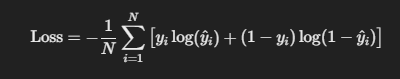

where:

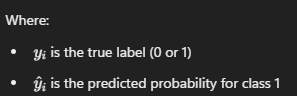

In [50]:
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-12  # Avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))



In [51]:
class LossMonitorCallback:
    def __init__(self):
        self.losses = []

    def callback(self, weights, iteration, cost):
        # Store the cost (proxy for the loss)
        self.losses.append(cost)
        if iteration % 10 == 0:
            print(f"Iteration {iteration}, Loss: {cost:.4f}")

loss_monitor = LossMonitorCallback()


✅ Step 4: Train the Quantum Model

Epoch 0, Loss: 0.5880
Epoch 10, Loss: 0.5880
Epoch 20, Loss: 0.5880
Epoch 30, Loss: 0.5880
Epoch 40, Loss: 0.5880
Epoch 50, Loss: 0.5880
Epoch 60, Loss: 0.5880
Epoch 70, Loss: 0.5880
Epoch 80, Loss: 0.5880
Epoch 90, Loss: 0.5880
Epoch 100, Loss: 0.5880
Epoch 110, Loss: 0.5880
Epoch 120, Loss: 0.5880
Epoch 130, Loss: 0.5880
Epoch 140, Loss: 0.5880
Epoch 150, Loss: 0.5880
Epoch 160, Loss: 0.5880
Epoch 170, Loss: 0.5880
Epoch 180, Loss: 0.5880
Epoch 190, Loss: 0.5880
Epoch 200, Loss: 0.5880
Epoch 210, Loss: 0.5880
Epoch 220, Loss: 0.5880
Epoch 230, Loss: 0.5880
Epoch 240, Loss: 0.5880
Epoch 250, Loss: 0.5880
Epoch 260, Loss: 0.5880
Epoch 270, Loss: 0.5880
Epoch 280, Loss: 0.5880
Epoch 290, Loss: 0.5880


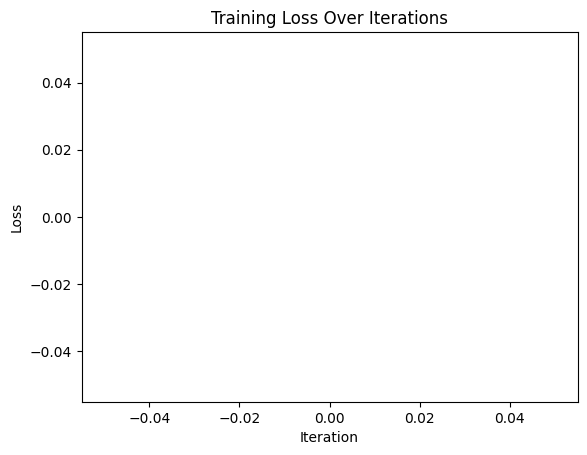

In [52]:
# Train the quantum classifier
# Initialize the VQC with loss monitoring
vqc = VQC(feature_map=feature_map, ansatz=ansatz, sampler=sampler, optimizer=optimizer)

from sklearn.metrics import log_loss
import numpy as np

# Store loss values to monitor progress
loss_values = []

def monitor_loss(vqc, X_train, y_train, epochs=300):
    # Train the VQC using its internal mechanism
    vqc.fit(X_train, y_train)

    # Manually track the loss after training
    for epoch in range(epochs):
        # Get the predicted probabilities
        y_pred_probs = vqc.predict_proba(X_train)

        # Compute cross-entropy loss
        loss = log_loss(y_train, y_pred_probs)
        loss_values.append(loss)

        # Print every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Monitor loss during training
monitor_loss(vqc, X_train_expanded, y_train, epochs=300)


# Plot the loss curve
import matplotlib.pyplot as plt

plt.plot(loss_monitor.losses)
plt.title("Training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()



✅ What This Does:

Trains the VQC model using a quantum simulator.
Optimizes parameters of the quantum circuit to minimize classification error.

✅ Step 5: Evaluate Model Performance

In [16]:
# Predict test data
y_pred = vqc.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Quantum Classifier Accuracy: {accuracy * 100:.2f}%")



Quantum Classifier Accuracy: 47.50%


Compare with Classical SVM

In [36]:
# Train classical SVM
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

# Predict and evaluate SVM
y_pred_svm = svm.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test)

print(f"Classical SVM Accuracy: {accuracy_svm * 100:.2f}%")


Classical SVM Accuracy: 97.50%
